In [1]:
from matplotlib import pyplot as plt
from itertools import combinations,permutations,product
import numpy as np
import argparse
import math
import cv2
import time

In [2]:
theta = np.arange(0, 180, 1)
cos = np.cos(np.deg2rad(theta))
sin = np.sin(np.deg2rad(theta))

### Normal Hough Transform

In [3]:
def hough_line(edge):
    # Generate a accumulator matrix to store the values
    start_time = time.time()
    rho_range = round(math.sqrt(edge.shape[0]**2 + edge.shape[1]**2))
    accumulator = np.zeros((2 * rho_range, len(theta)))

    # Threshold to get edges pixel location (x,y)
    edge_pixels = np.where(edge == 255)
    coordinates = list(zip(edge_pixels[0], edge_pixels[1]))
    # Calculate rho value for each edge location (x,y) with all the theta range
    for p in range(len(coordinates)):
        for t in range(len(theta)):
            rho = int(round(coordinates[p][1] * cos[t] + coordinates[p][0] * sin[t]))
            accumulator[rho, t] += 2 # Suppose add 1 only, Just want to get clear result
    print("--- %s seconds ---" % (time.time() - start_time))
    return accumulator
    # .astype('uint8')

In [4]:
k=8

#### Simple Padding to make the image square

In [5]:
def padd(image):
    m=max(image.shape[0],image.shape[1])
    if(m%k==0):
        m=m
    else:
        m=((m//k)+1)*k
    # read image
    # create new image of desired size and color (blue) for padding
    color = (0,0,0)
    result = np.full((m,m,image.shape[2]), color)

    # compute center offset
    x_center = (m - image.shape[1]) // 2
    y_center = (m - image.shape[0]) // 2

    # copy img image into center of result image
    result[y_center:y_center+image.shape[0], 
        x_center:x_center+image.shape[1]] = image

    # view result
    return result.astype('uint8'),m

--- 0.7487473487854004 seconds ---


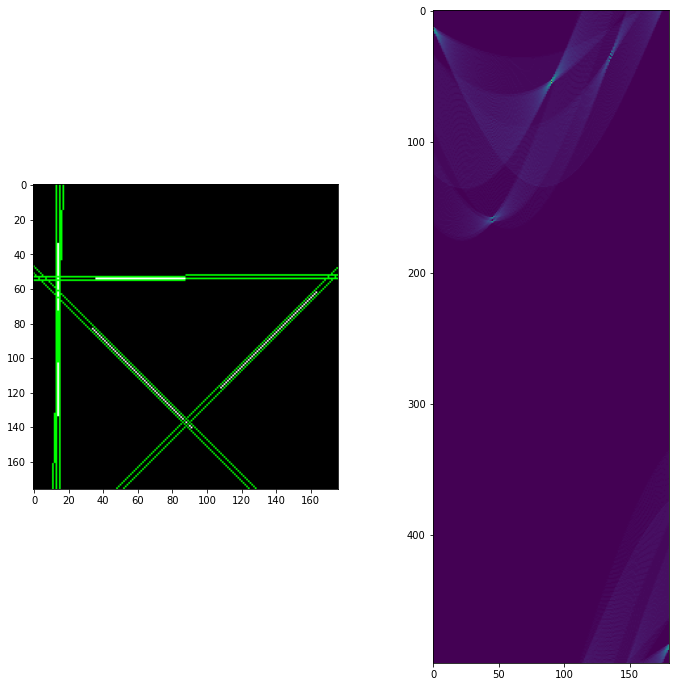

In [6]:
# read image then convert to grayscale and find the edges by Canny Edge Detection
path = r'C:\Users\rhuth\Desktop\Hough\Hough-Transform-Line-Detection\line.png'
  
# Using cv2.imread() method
image = cv2.imread(path)
image,m=padd(image)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(grayscale,50,150)

# Function to do hough line transform
accumulator1 = hough_line(edges)

# Threshold some high values then draw the line
edge_pixels = np.where(accumulator1 > 110)
coordinates = list(zip(edge_pixels[0], edge_pixels[1]))

# Use line equation to draw detected line on an original image
for i in range(0, len(coordinates)):
    a = np.cos(np.deg2rad(coordinates[i][1]))
    b = np.sin(np.deg2rad(coordinates[i][1]))
    x0 = a*coordinates[i][0]
    y0 = b*coordinates[i][0]
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(image,(x1,y1),(x2,y2),(0,255,0),1)

# show result
plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(image)
plt.subplot(122), plt.imshow(accumulator1)
plt.show()

### Additive Hough Transform

In [7]:
o=int(m/k) #number of local origins present in the image

#### Finding rho values of the local origins

In [8]:
def local_origins(k,o):
    coord=np.ones([k+1,k+1,180],dtype=int)*(-1)
    for i in range(0,k+1):
        for j in range(0,k+1):
            for t in range(0,180):
                coord[i][j][t] = int(i*o* cos[t] + j*o* sin[t])
    return coord


#### Finding the rho values of the first block

In [13]:
def lht(o):
    # coord = [[-1]*o]*o*90
    coord=np.ones([o,o,180],dtype=int)*(-1)
    for i in range(0,o):
        for j in range(0,o):
            for t in range(0,180):
                coord[i][j][t] = int(i* cos[t] + j* sin[t])
    return coord

In [14]:
w=image.shape[0]//k #This is the length of side of an individual block we have made

#### We add rho values of local origins and initial block to get rho of the original image

In [15]:
def add(edge):
    edge_pixels = np.where(edge == 255)
    coordinates = list(zip(edge_pixels[0], edge_pixels[1]))
    rho_range = round(math.sqrt(edge.shape[0]**2 + edge.shape[1]**2))
    accumulator = np.zeros((2 * rho_range, len(theta)))
    w=edge.shape[0]//k
    LHT=lht(o)
    LO=local_origins(k,o)
    start_time = time.time()
    for p in range(len(coordinates)):
        for t in range(len(theta)):
            lh=LHT[coordinates[p][1]-closest_value(coordinates[p][1])][coordinates[p][0]-closest_value(coordinates[p][0])][t]
            lo=LO[(closest_value(coordinates[p][1]))//w][(closest_value(coordinates[p][0]))//w][t]
            rho =lh+lo
            accumulator[rho, t] += 2 # Suppose add 1 only, Just want to get clear result
    print("--- %s seconds ---" % (time.time() - start_time))
    return accumulator
    #.astype('uint8')

In [17]:
def closest_value(a):
  return (a//w)*w #This returns the closest local origin to the pixel


--- 0.4150245189666748 seconds ---


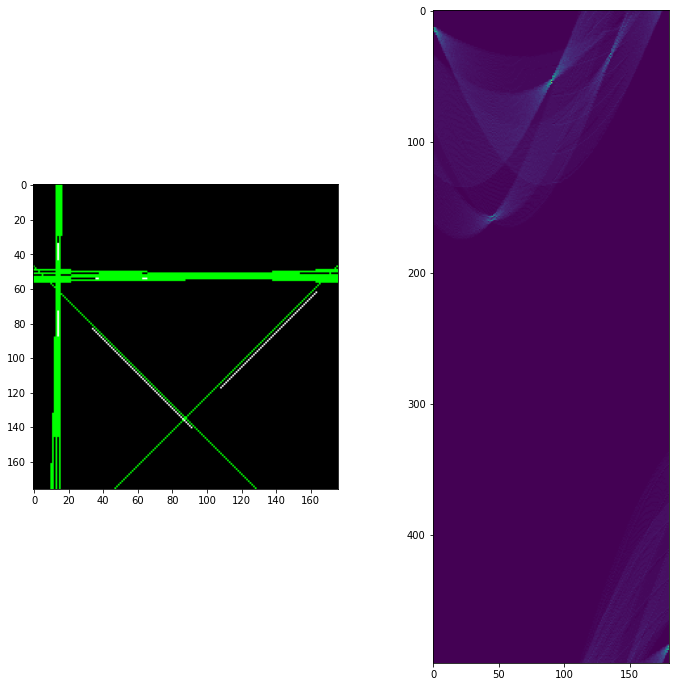

In [18]:
path = r'C:\Users\rhuth\Desktop\Hough\Hough-Transform-Line-Detection\line.png'
  
# Using cv2.imread() method
image = cv2.imread(path)
image,m=padd(image)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(grayscale,50,150)

accumulator = add(edges)

# Threshold some high values then draw the line
edge_pixels = np.where(accumulator > 110)
coordinates = list(zip(edge_pixels[0], edge_pixels[1]))

# Use line equation to draw detected line on an original image
for i in range(0, len(coordinates)):
    a = np.cos(np.deg2rad(coordinates[i][1]))
    b = np.sin(np.deg2rad(coordinates[i][1]))
    x0 = a*coordinates[i][0]
    y0 = b*coordinates[i][0]
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(image,(x1,y1),(x2,y2),(0,255,0),1)

# show result
plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(image)
plt.subplot(122), plt.imshow(accumulator)
plt.show()

-118.0


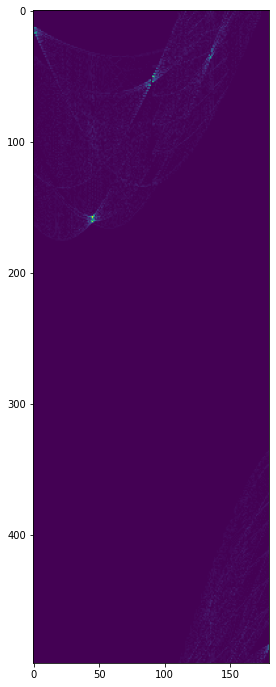

In [19]:
sub= accumulator1-accumulator
# print(sub)
print(np.min(sub))
plt.figure(figsize=(12, 12))
plt.imshow(np.abs(sub))

### The OpenCV hough

(20, 1, 2)


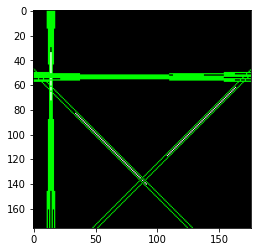

In [20]:
# read image then convert to grayscale and find the edges by Canny Edge Detection
path = r'C:\Users\rhuth\Desktop\Hough\Hough-Transform-Line-Detection\line.png'
  
# Using cv2.imread() method
image = cv2.imread(path)
image,m=padd(image)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# edges = cv2.Canny(grayscale,50,150)
edges=cv2.Canny(grayscale, 50, 200, None, 3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 46, None, 0, 0)
# print(len(lines))
print(lines.shape)
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(image, pt1, pt2, (0,255,0), 1)
plt.imshow(image)